In [948]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [755]:
def load_application_train():
    data = pd.read_csv("german_credit_data.csv")
    return data

df = load_application_train()

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [756]:
# Shuffle the DataFrame
df = df.sample(frac=1, random_state = 42).reset_index(drop=True)

In [757]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,521,24,female,2,own,little,little,3190,18,radio/TV,bad
1,737,35,male,1,own,moderate,little,4380,18,car,good
2,740,32,male,2,own,moderate,little,2325,24,car,good
3,660,23,male,2,rent,little,rich,1297,12,radio/TV,good
4,411,35,male,3,own,little,NaN,7253,33,car,good


## Data Preprocessing

In [758]:
def check_df(dataframe, head = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.95, 0.99, 1]).T)

In [759]:
check_df(df)


##################### Shape #####################
(1000, 11)
##################### Types #####################
Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object
##################### Head #####################
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0         521   24  female    2     own          little           little   
1         737   35    male    1     own        moderate           little   
2         740   32    male    2     own        moderate           little   
3         660   23    male    2    rent          little             rich   
4         411   35    male    3     own          little              NaN   

   Credit amount  Duration   Purpose  Risk  
0           3190        18 

In [760]:
def grab_col_names(dataframe, categorical_threshold = 10, cardinal_threshold = 20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be taken
        cat_th: int, optional
                Class threshold value for variables that are numeric but categorical
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 lists that return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """
    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    
    # Numerical columns that behave like categorical based on the threshold categorical_threshold
    numeric_looking_but_categorical = [col for col in dataframe.columns if dataframe[col].dtype != "O" and dataframe[col].nunique() < categorical_threshold]
    
    # Categorical columns that behave like numerical based on the threshold cardinal_threshold
    categorical_looking_but_cardinal = [col for col in dataframe.columns  if dataframe[col].dtype == "O" and dataframe[col].nunique() > cardinal_threshold]
    
    categorical_cols = categorical_cols + numeric_looking_but_categorical
    
    categorical_cols = [col for col in categorical_cols if col not in categorical_looking_but_cardinal]
    
    numeric_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O"]
    
    numeric_cols = [col for col in numeric_cols if col not in numeric_looking_but_categorical]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"Categorical Columns: {len(categorical_cols)}")
    print(f"Numeric Columns: {len(numeric_cols)}")
    print(f"Categorical Looking but Cardinal: {len(categorical_looking_but_cardinal)}")
    print(f"Numeric Looking but Categorical: {len(numeric_looking_but_categorical)}")
    return categorical_cols, numeric_cols, categorical_looking_but_cardinal

In [761]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1000
Variables: 11
Categorical Columns: 7
Numeric Columns: 4
Categorical Looking but Cardinal: 0
Numeric Looking but Categorical: 1


In [762]:
cat_cols

['Sex',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Purpose',
 'Risk',
 'Job']

In [763]:
num_cols

['Unnamed: 0', 'Age', 'Credit amount', 'Duration']

In [764]:
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [765]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1000
Variables: 10
Categorical Columns: 7
Numeric Columns: 3
Categorical Looking but Cardinal: 0
Numeric Looking but Categorical: 1


In [766]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,24,female,2,own,little,little,3190,18,radio/TV,bad
1,35,male,1,own,moderate,little,4380,18,car,good
2,32,male,2,own,moderate,little,2325,24,car,good
3,23,male,2,rent,little,rich,1297,12,radio/TV,good
4,35,male,3,own,little,NaN,7253,33,car,good


In [767]:
cat_but_car

[]

## Analyzing the numerical and categorical variables.

In [768]:
def categorical_summary(dataframe, col_name, plot = False):
    # Display value counts and ratios in a DataFrame
    print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                       "Ratio" : dataframe[col_name].value_counts()/ len(dataframe)}))
    
    # Generate a count plot if plot is True
    if plot:
        plt.figure(figsize=(12,6))
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block=True)

        Sex  Ratio
male    690  0.690
female  310  0.310


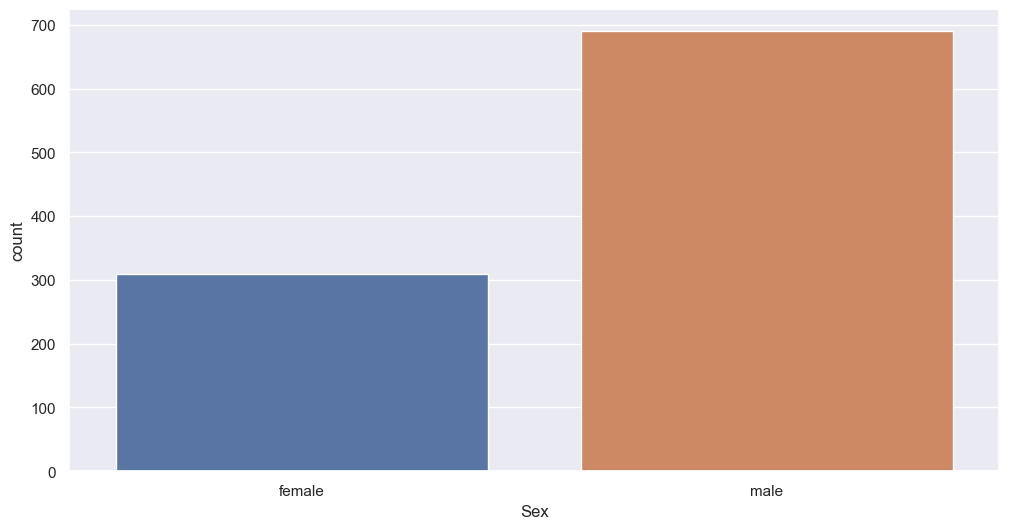

      Housing  Ratio
own       713  0.713
rent      179  0.179
free      108  0.108


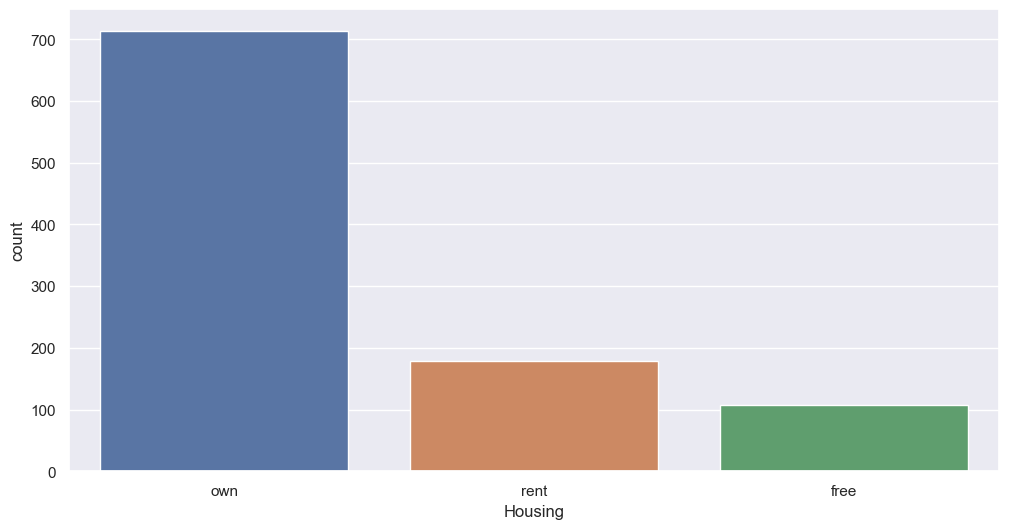

            Saving accounts  Ratio
little                  603  0.603
moderate                103  0.103
quite rich               63  0.063
rich                     48  0.048


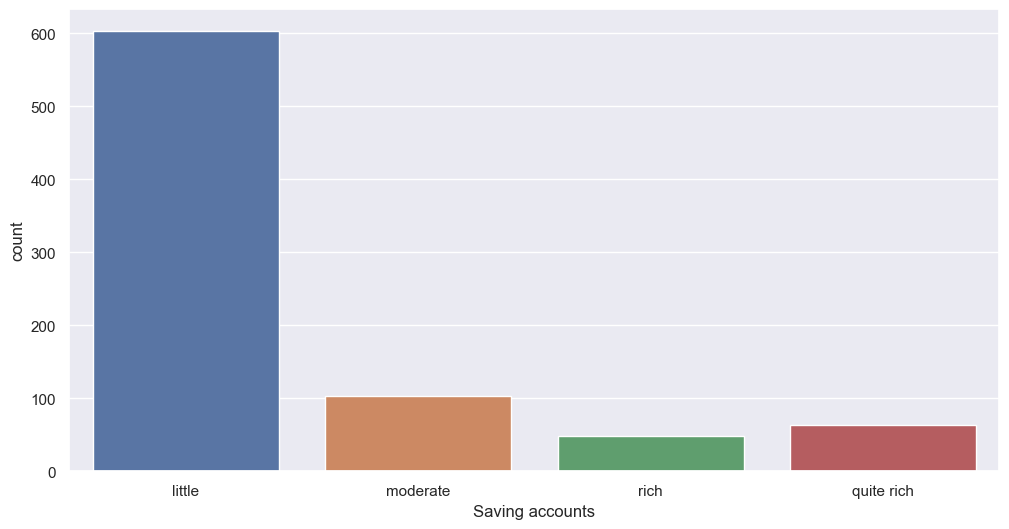

          Checking account  Ratio
little                 274  0.274
moderate               269  0.269
rich                    63  0.063


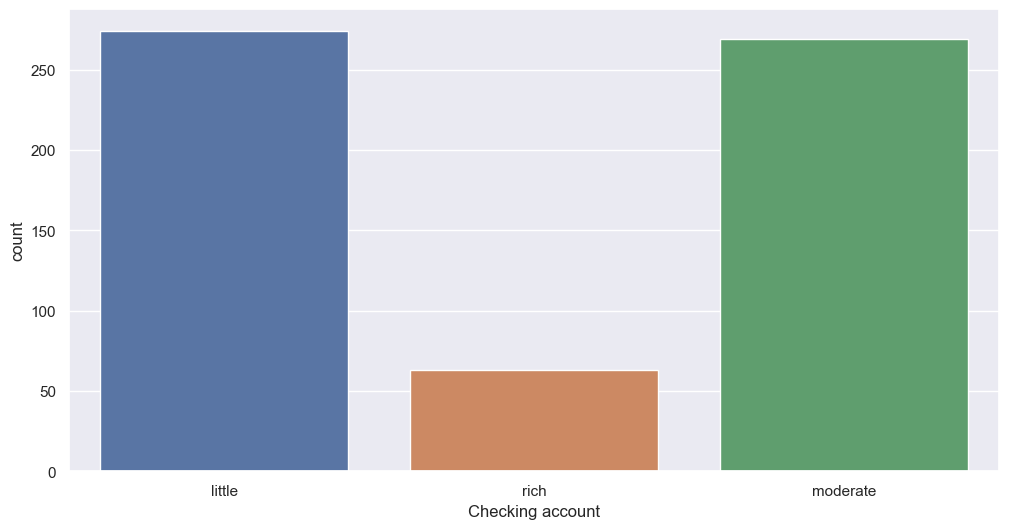

                     Purpose  Ratio
car                      337  0.337
radio/TV                 280  0.280
furniture/equipment      181  0.181
business                  97  0.097
education                 59  0.059
repairs                   22  0.022
domestic appliances       12  0.012
vacation/others           12  0.012


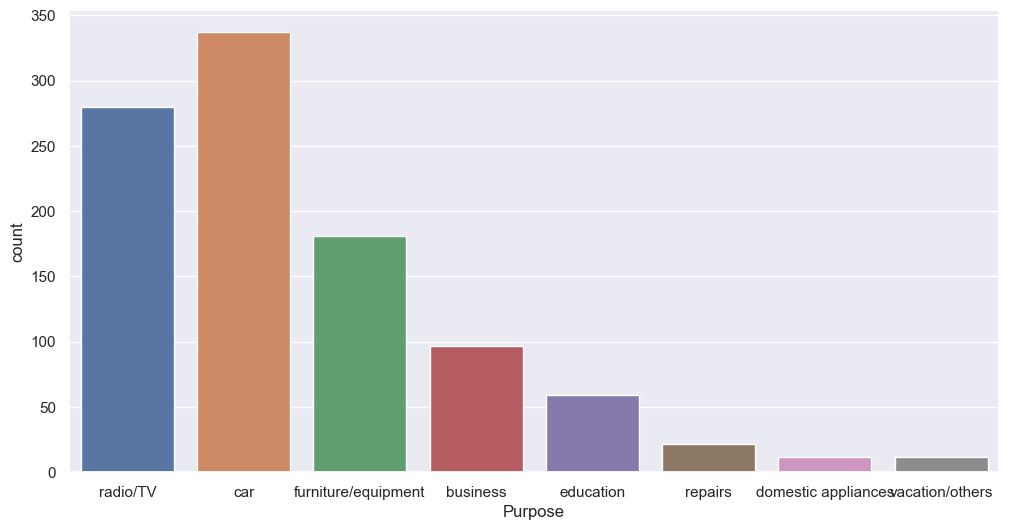

      Risk  Ratio
good   700  0.700
bad    300  0.300


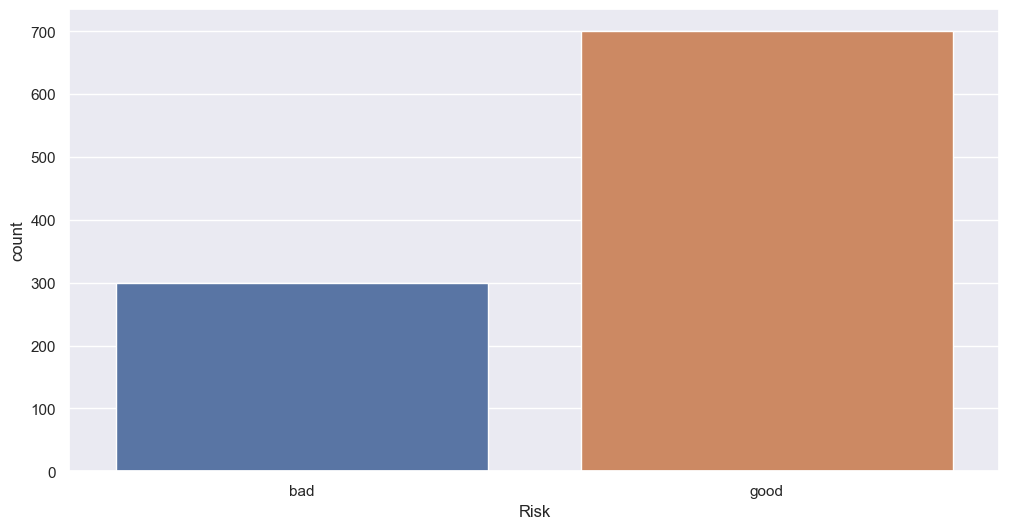

   Job  Ratio
2  630  0.630
1  200  0.200
3  148  0.148
0   22  0.022


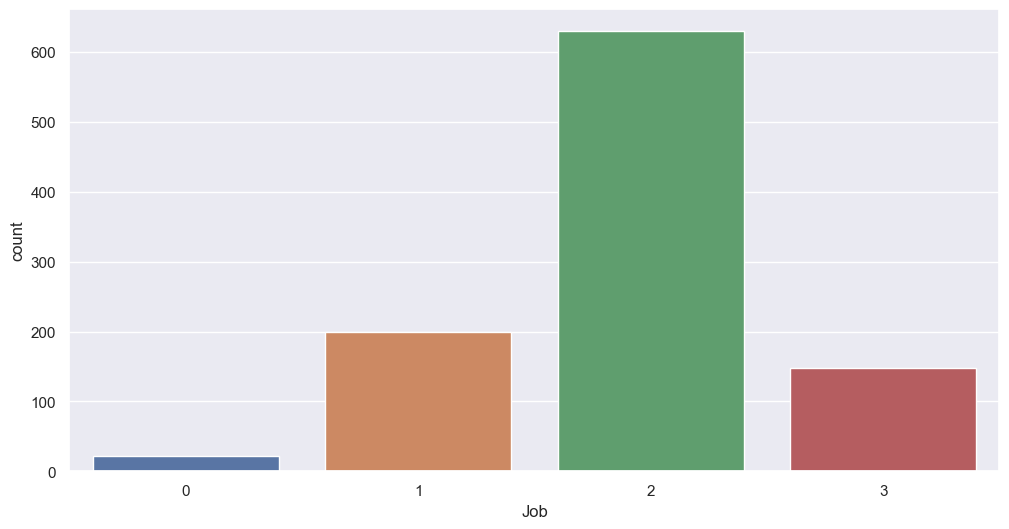

In [769]:
for col in cat_cols:
    categorical_summary(df, col, True)

In [770]:
def numerical_summary(dataframe, col_name, plot = False):
    # Define quantiles for detailed description
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)
    
    if plot:
        plt.figure(figsize=(8,6))
        dataframe[col_name].hist(bins = 20)
        plt.title(col_name)
        plt.xlabel(col_name)
        plt.show()

count   1000.000
mean      35.546
std       11.375
min       19.000
5%        22.000
10%       23.000
20%       26.000
30%       28.000
40%       30.000
50%       33.000
60%       36.000
70%       39.000
80%       45.000
90%       52.000
95%       60.000
99%       67.010
max       75.000
Name: Age, dtype: float64


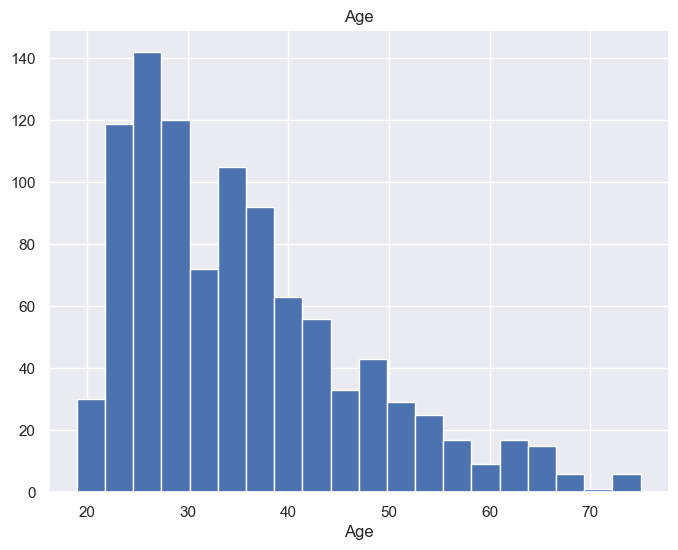

count    1000.000
mean     3271.258
std      2822.737
min       250.000
5%        708.950
10%       932.000
20%      1262.000
30%      1479.400
40%      1906.800
50%      2319.500
60%      2852.400
70%      3590.000
80%      4720.000
90%      7179.400
95%      9162.700
99%     14180.390
max     18424.000
Name: Credit amount, dtype: float64


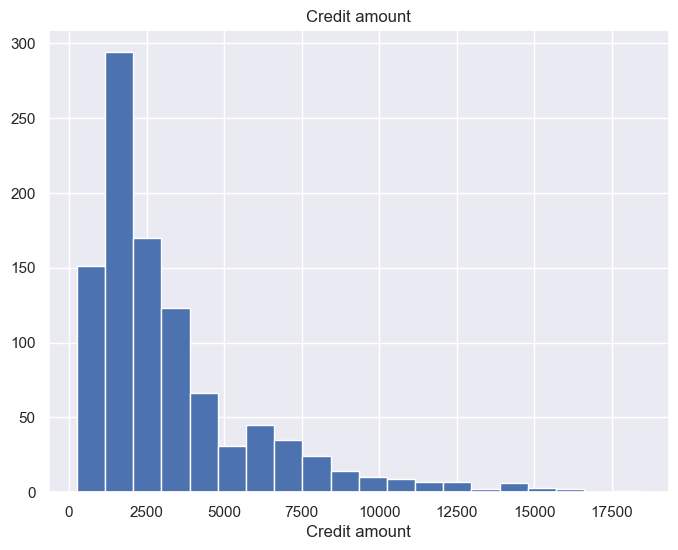

count   1000.000
mean      20.903
std       12.059
min        4.000
5%         6.000
10%        9.000
20%       12.000
30%       12.000
40%       15.000
50%       18.000
60%       24.000
70%       24.000
80%       30.000
90%       36.000
95%       48.000
99%       60.000
max       72.000
Name: Duration, dtype: float64


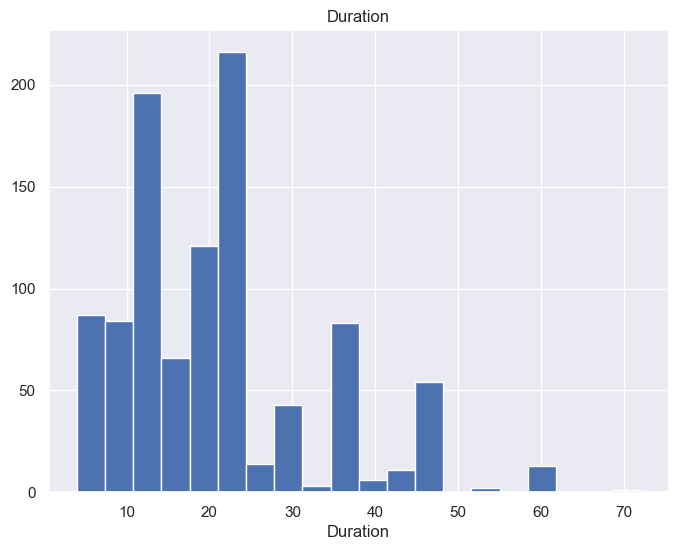

In [771]:
for col in num_cols:
    numerical_summary(df,col,True)

## Performing target variable analysis.

In [772]:
def target_summary_with_num(dataframe, target, col_name):
    # Group the DataFrame by the target variable and calculate the mean of the numerical column
    print(dataframe.groupby(target).agg({col_name : "mean"}))

In [773]:
for col in num_cols:
    target_summary_with_num(df, "Risk", col)

        Age
Risk       
bad  33.963
good 36.224
      Credit amount
Risk               
bad        3938.127
good       2985.457
      Duration
Risk          
bad     24.860
good    19.207


In [774]:
df['Risk'] = df['Risk'].replace({'good': 0, 'bad': 1}, regex=True)

In [775]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,24,female,2,own,little,little,3190,18,radio/TV,1
1,35,male,1,own,moderate,little,4380,18,car,0
2,32,male,2,own,moderate,little,2325,24,car,0
3,23,male,2,rent,little,rich,1297,12,radio/TV,0
4,35,male,3,own,little,NaN,7253,33,car,0


In [776]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [777]:
for col in cat_cols:
    target_summary_with_cat(df, "Risk", col)

        TARGET_MEAN
Sex                
female        0.352
male          0.277


         TARGET_MEAN
Housing             
free           0.407
own            0.261
rent           0.391


                 TARGET_MEAN
Saving accounts             
little                 0.360
moderate               0.330
quite rich             0.175
rich                   0.125


                  TARGET_MEAN
Checking account             
little                  0.493
moderate                0.390
rich                    0.222


                     TARGET_MEAN
Purpose                         
business                   0.351
car                        0.315
domestic appliances        0.333
education                  0.390
furniture/equipment        0.320
radio/TV                   0.221
repairs                    0.364
vacation/others            0.417


      TARGET_MEAN
Risk             
0           0.000
1           1.000


     TARGET_MEAN
Job             
0          0.318
1          0.280
2        

## Analyzing outliers

In [778]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    """
    Calculate lower and upper thresholds for identifying outliers in a numerical column.

    Parameters:
    - dataframe: pandas DataFrame
    - col_name: name of the numerical column
    - q1: the first quartile (default is 0.25)
    - q3: the third quartile (default is 0.75)

    Returns:
    - low: lower threshold for outliers
    - up: upper threshold for outliers
    """
    
    # Calculate the first and third quartiles
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    
    # Calculate the interquartile range (IQR)
    interquartile = quartile3 - quartile1
    
    # Calculate the upper and lower thresholds for outliers using 1.5 times the IQR
    up = quartile3 + 1.5 * interquartile 
    low = quartile1 - 1.5 * interquartile
    return low, up

In [779]:
def check_outlier(dataframe, col_name):
    
    """
    Check for outliers in a numerical column based on the calculated thresholds.

    Parameters:
    - dataframe: pandas DataFrame
    - col_name: name of the numerical column

    Returns:
    - True if outliers are present, False otherwise
    """
    
    # Calculate lower and upper thresholds for outliers
    # Note: Since there are too many outliers in the data and we do not want any loss of data, the thresholds were updated to 0.05 and 0.95.
    low, up = outlier_thresholds(dataframe, col_name,0.1,0.9)
    
    
    if dataframe[(dataframe[col_name] > up) | (dataframe[col_name] < low)].any(axis= None):
        return True
    else:
        return False


In [780]:
for col in num_cols:
    print(col, check_outlier(df,col))

Age False
Credit amount True
Duration False


In [781]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    """
    Replace values in a numerical column with lower and upper thresholds to handle outliers.

    Parameters:
    - dataframe: pandas DataFrame
    - variable: name of the numerical column
    - q1: the first quartile (default is 0.25)
    - q3: the third quartile (default is 0.75)

    Returns:
    None
    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    
    # Replace values below the lower threshold with the lower threshold
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    
    # Replace values above the upper threshold with the upper threshold
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [782]:
for col in num_cols:
    if check_outlier(df,col):
        replace_with_thresholds(df,col,0.1,0.9)

In [783]:
for col in num_cols:
    print(col, check_outlier(df,col))

Age False
Credit amount False
Duration False


## Performing missing observation analysis.

In [784]:
df.isnull().values.any()

True

In [785]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [786]:
df.isnull().sum().sum()

577

In [787]:
def missing_values_table(dataframe, na_name=False):
    """
    Display a table summarizing missing values in the DataFrame.

    Parameters:
    - dataframe: pandas DataFrame
    - na_name: whether to return the names of columns with missing values (default is False)

    Returns:
    - If na_name is True, returns a list of column names with missing values.
      Otherwise, prints a table summarizing missing values.
    """
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    missing_df = pd.concat([n_miss,ratio], axis = 1, keys = ["n_miss","ratio"])
    print(missing_df, end="\n")
    
    if na_name:
        return na_columns

In [788]:
na_cols = missing_values_table(df,True)

                  n_miss  ratio
Checking account     394 39.400
Saving accounts      183 18.300


In [789]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(),1,0)
        
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                           "Count" : temp_df.groupby(col)[target].count()}))

In [790]:
missing_vs_target(df, "Risk", na_cols)

                         TARGET_MEAN  Count
Saving accounts_NA_FLAG                    
0                              0.328    817
1                              0.175    183
                          TARGET_MEAN  Count
Checking account_NA_FLAG                    
0                               0.419    606
1                               0.117    394


In [791]:
df.drop("Checking account", axis = 1, inplace = True)

In [792]:
na_cols = missing_values_table(df,True)

                 n_miss  ratio
Saving accounts     183 18.300


In [793]:
 df["Saving accounts"] = df["Saving accounts"].fillna(df["Saving accounts"].mode().iloc[0]) 

In [794]:
na_cols = missing_values_table(df,True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [795]:
df.isnull().values.any()

False

## Performing correlation analysis.

In [796]:
df[num_cols].corr()

,Age,Credit amount,Duration
Age,1.000,0.033,-0.036
Credit amount,0.033,1.000,0.626
Duration,-0.036,0.626,1.000


In [797]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu", annot=True)
        plt.show(block=True)
    return drop_list

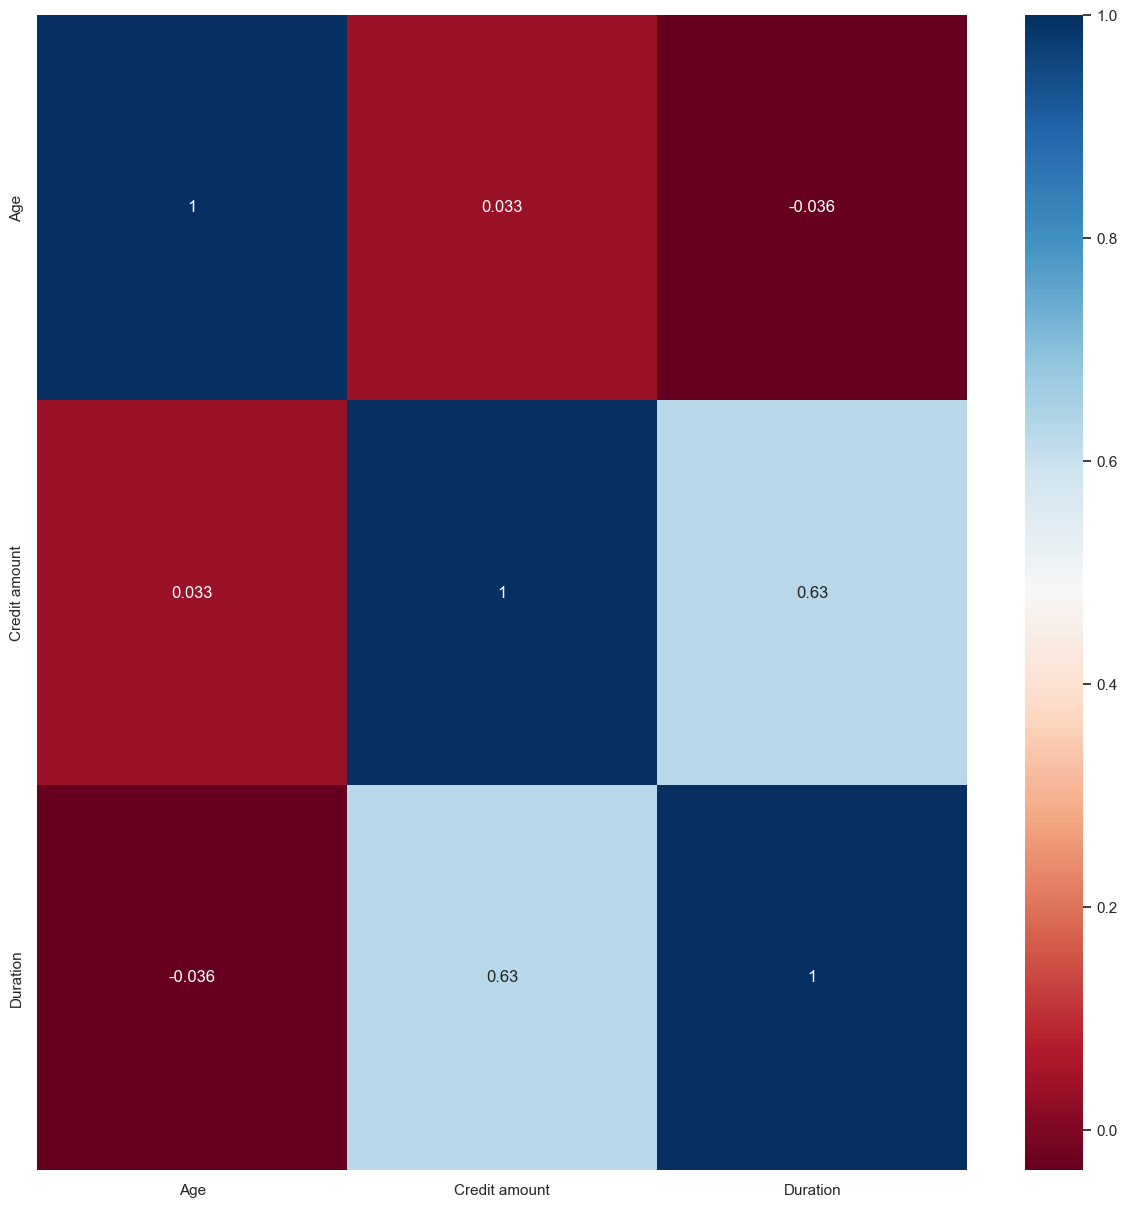

[]

In [798]:
high_correlated_cols(df[num_cols], plot=True)

## Feautre Engineering

In [799]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,24,female,2,own,little,3190.000,18,radio/TV,1
1,35,male,1,own,moderate,4380.000,18,car,0
2,32,male,2,own,moderate,2325.000,24,car,0
3,23,male,2,rent,little,1297.000,12,radio/TV,0
4,35,male,3,own,little,7253.000,33,car,0


In [800]:
df["NEW_monthly_repayment"] = df["Credit amount"] / df["Duration"]
df["NEW_Age*Job"] = df["Age"] * df["Job"]

df['NEW_Housing*Job'] = df['Housing'].map({"free": 1, "rent": 2, "own": 3}) * (df['Job'] + 1)


bins = [0, 25, 40, 65, 100]  # Define age group boundaries
labels = ['Young',"Adult", 'Middle-Age', 'Old']
df['NEW_CatAge'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


    

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1000
Variables: 13
Categorical Columns: 8
Numeric Columns: 5
Categorical Looking but Cardinal: 0
Numeric Looking but Categorical: 4


## Encoding Operations

In [801]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk,NEW_monthly_repayment,NEW_Age*Job,NEW_Housing*Job,NEW_CatAge
0,24,female,2,own,little,3190.000,18,radio/TV,1,177.222,48,9,Young
1,35,male,1,own,moderate,4380.000,18,car,0,243.333,35,6,Adult
2,32,male,2,own,moderate,2325.000,24,car,0,96.875,64,9,Adult
3,23,male,2,rent,little,1297.000,12,radio/TV,0,108.083,46,6,Young
4,35,male,3,own,little,7253.000,33,car,0,219.788,105,12,Adult


### Label Encoding

In [802]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
              and df[col].nunique() == 2]

In [803]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [804]:
binary_cols

['Sex', 'Risk']

In [805]:
binary_cols.remove("Risk")

In [806]:
binary_cols

['Sex']

In [807]:
for col in binary_cols:
    label_encoder(df, col)

In [808]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk,NEW_monthly_repayment,NEW_Age*Job,NEW_Housing*Job,NEW_CatAge
0,24,0,2,own,little,3190.000,18,radio/TV,1,177.222,48,9,Young
1,35,1,1,own,moderate,4380.000,18,car,0,243.333,35,6,Adult
2,32,1,2,own,moderate,2325.000,24,car,0,96.875,64,9,Adult
3,23,1,2,rent,little,1297.000,12,radio/TV,0,108.083,46,6,Young
4,35,1,3,own,little,7253.000,33,car,0,219.788,105,12,Adult


### One Hot Encoding

In [809]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1000
Variables: 13
Categorical Columns: 8
Numeric Columns: 5
Categorical Looking but Cardinal: 0
Numeric Looking but Categorical: 5


In [810]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [811]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [812]:
ohe_cols

['Job',
 'Housing',
 'Saving accounts',
 'Purpose',
 'NEW_Housing*Job',
 'NEW_CatAge']

In [813]:
df = one_hot_encoder(df, ohe_cols, drop_first=True)
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 1000
Variables: 32
Categorical Columns: 27
Numeric Columns: 5
Categorical Looking but Cardinal: 0
Numeric Looking but Categorical: 27


In [814]:
df.head()

,Age,Sex,Credit amount,Duration,Risk,NEW_monthly_repayment,NEW_Age*Job,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,NEW_Housing*Job_2,NEW_Housing*Job_3,NEW_Housing*Job_4,NEW_Housing*Job_6,NEW_Housing*Job_8,NEW_Housing*Job_9,NEW_Housing*Job_12,NEW_CatAge_Adult,NEW_CatAge_Middle-Age,NEW_CatAge_Old
0,24,0,3190.000,18,1,177.222,48,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,35,1,4380.000,18,0,243.333,35,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,32,1,2325.000,24,0,96.875,64,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,23,1,1297.000,12,0,108.083,46,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,35,1,7253.000,33,0,219.788,105,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


## Standardize for numeric variables.

In [815]:
num_cols

['Age', 'Credit amount', 'Duration', 'NEW_monthly_repayment', 'NEW_Age*Job']

In [816]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [817]:
df[num_cols].head()

,Age,Credit amount,Duration,NEW_monthly_repayment,NEW_Age*Job
0,-1.015,-0.028,-0.241,0.062,-0.581
1,-0.048,0.395,-0.241,0.494,-0.963
2,-0.312,-0.336,0.257,-0.461,-0.111
3,-1.103,-0.701,-0.739,-0.388,-0.640
4,-0.048,1.417,1.004,0.340,1.092


## Modeling

In [818]:
y = df["Risk"]
X = df.drop(["Risk"], axis = 1) 

### DECISION TREE

In [819]:
decision_tree_model = DecisionTreeClassifier(random_state=17).fit(X, y)

In [820]:
cv_results = cross_validate(decision_tree_model, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [821]:
cv_results['test_accuracy'].mean()

0.6100000000000001

In [822]:
cv_results['test_f1'].mean()

0.363638886088648

In [823]:
cv_results['test_roc_auc'].mean()

0.5423809523809524

In [824]:
cv_results['test_precision'].mean()

0.3554696247034334

In [825]:
cv_results['test_recall'].mean()

0.37333333333333335

In [828]:

    decision_tree_params = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        "max_depth" : list(range(1,11))+[None],
        "min_samples_split": range(2,20),
        "min_samples_leaf": [1, 2, 4, 8, 16]
    }

In [830]:
decision_tree_best_grid = GridSearchCV(decision_tree_model,
                             decision_tree_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=1).fit(X,y)

Fitting 5 folds for each of 3960 candidates, totalling 19800 fits


In [833]:
decision_tree_best_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 16,
 'min_samples_split': 2,
 'splitter': 'best'}

In [834]:
decision_tree_final = DecisionTreeClassifier(**decision_tree_best_grid.best_params_, random_state=17).fit(X,y)

In [835]:
cv_results = cross_validate(decision_tree_final, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [836]:
cv_results['test_accuracy'].mean()

0.709

In [837]:
cv_results['test_f1'].mean()

0.2644153507311402

In [838]:
cv_results['test_roc_auc'].mean()

0.6137380952380953

In [839]:
cv_results['test_precision'].mean()

0.5513082437275986

In [840]:
cv_results['test_recall'].mean()

0.18333333333333335

### Random Forest

In [850]:
rf_model = RandomForestClassifier(random_state=17)


In [851]:
cv_results = cross_validate(rf_model, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [852]:
cv_results['test_accuracy'].mean()

0.703

In [853]:
cv_results['test_f1'].mean()

0.3549136190858788

In [854]:
cv_results['test_roc_auc'].mean()

0.6532857142857142

In [855]:
cv_results['test_precision'].mean()

0.5115083735773391

In [856]:
cv_results['test_recall'].mean()

0.2733333333333333

In [857]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [858]:
rf_params = {"max_depth" : [5, 8, 10, 20, None],
            "max_features": [3,5,7,"auto"],
             "min_samples_split":[2, 5, 8, 10, 15, 20],
             "n_estimators":[50, 100,200,500]
            }

In [859]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv = 5, n_jobs=-1, verbose = True).fit(X,y)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


C:\Users\siyar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
600 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
179 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\siyar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\siyar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\siyar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py

In [860]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state = 17).fit(X,y)

In [861]:
cv_results = cross_validate(rf_final, X, y,
                           cv= 5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])

In [862]:
cv_results['test_accuracy'].mean()

0.7230000000000001

In [863]:
cv_results['test_f1'].mean()

0.3092458648724419

In [864]:
cv_results['test_roc_auc'].mean()

0.6755

In [865]:
cv_results['test_precision'].mean()

0.6255218855218855

In [866]:
cv_results['test_recall'].mean()

0.21000000000000002

### Gradient Boosting

In [870]:
gbm_model = GradientBoostingClassifier(random_state=17)

In [905]:
cv_results = cross_validate(gbm_model, X, y, cv = 5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [906]:
cv_results['test_accuracy'].mean()

0.7180000000000001

In [907]:
cv_results['test_f1'].mean()

0.29289518221076005

In [908]:
cv_results['test_roc_auc'].mean()

0.6644642857142857

In [909]:
cv_results['test_precision'].mean()

0.6234805194805195

In [910]:
cv_results['test_recall'].mean()

0.19666666666666668

In [911]:
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [912]:
gbm_params = {"learning_rate": [0.01, 0.1, 0.2],
              "max_depth": [3, 4, 5, 6, 8, 10],
              "n_estimators": [25, 50, 100, 200, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [913]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [914]:
gbm_best_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1}

In [915]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state = 17).fit(X,y)

In [916]:
cv_results = cross_validate(gbm_final, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [917]:
cv_results['test_accuracy'].mean()

0.7180000000000001

In [918]:
cv_results['test_f1'].mean()

0.29289518221076005

In [919]:
cv_results['test_roc_auc'].mean()

0.6644642857142857

In [920]:
cv_results['test_precision'].mean()

0.6234805194805195

In [921]:
cv_results['test_recall'].mean()

0.19666666666666668

### SVM

In [927]:
svc_model = SVC(kernel = "rbf")

In [928]:
cv_results = cross_validate(svc_model, X, y, cv = 5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [929]:
cv_results['test_accuracy'].mean()

0.7140000000000001

In [930]:
cv_results['test_f1'].mean()

0.22714743744032395

In [931]:
cv_results['test_roc_auc'].mean()

0.6765476190476191

In [932]:
cv_results['test_precision'].mean()

0.6109105763517528

In [933]:
cv_results['test_recall'].mean()

0.14333333333333334

In [934]:
svc_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [935]:
svc_params = {"C": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
             "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10 ,50 ,100,'auto'],
             'kernel': ['linear', 'rbf', 'poly']}




In [936]:
svc_best_grid = GridSearchCV(svc_model, svc_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\siyar\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [937]:
svc_best_grid.best_params_

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

In [938]:
svc_final = svc_model.set_params(**svc_best_grid.best_params_, random_state = 17).fit(X,y)

In [939]:
cv_results = cross_validate(svc_final, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [940]:
cv_results['test_accuracy'].mean()

0.7180000000000001

In [941]:
cv_results['test_f1'].mean()

0.24619725774470252

In [942]:
cv_results['test_roc_auc'].mean()

0.6702380952380953

In [943]:
cv_results['test_precision'].mean()

0.6307464973368864

In [944]:
cv_results['test_recall'].mean()

0.15666666666666668

### Neural Networks

In [949]:
mlpc_model = MLPClassifier()

In [950]:
cv_results = cross_validate(mlpc_model, X, y, cv = 5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [951]:
cv_results['test_accuracy'].mean()

0.692

In [952]:
cv_results['test_f1'].mean()

0.36827694723738225

In [953]:
cv_results['test_roc_auc'].mean()

0.6668333333333333

In [954]:
cv_results['test_precision'].mean()

0.483165383662278

In [955]:
cv_results['test_recall'].mean()

0.30333333333333334

In [956]:
mlpc_model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [962]:
mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.001, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10), (100,100,100), (100,100), (3,5), (5, 3), (50,), (100,), (50, 50), (100, 50)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": [ 'tanh', "relu", "logistic"]}


In [963]:
mlpc_best_grid = GridSearchCV(mlpc_model, mlpc_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 567 candidates, totalling 2835 fits


In [964]:
mlpc_best_grid.best_params_

{'activation': 'tanh',
 'alpha': 0.01,
 'hidden_layer_sizes': (5, 3),
 'solver': 'adam'}

In [965]:
mlpc_final = mlpc_model.set_params(**mlpc_best_grid.best_params_, random_state = 17).fit(X,y)

In [966]:
cv_results = cross_validate(mlpc_final, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [967]:
cv_results['test_accuracy'].mean()

0.702

In [968]:
cv_results['test_f1'].mean()

0.2893807617340063

In [969]:
cv_results['test_roc_auc'].mean()

0.6650952380952381

In [970]:
cv_results['test_precision'].mean()

0.5196482969607443

In [971]:
cv_results['test_recall'].mean()

0.2033333333333333

### XGBoost

In [977]:
xgboost_model = XGBClassifier(random_state = 17)

In [978]:
cv_results = cross_validate(xgboost_model, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [979]:
cv_results['test_accuracy'].mean()

0.677

In [980]:
cv_results['test_f1'].mean()

0.377661614175029

In [981]:
cv_results['test_roc_auc'].mean()

0.6425000000000001

In [982]:
cv_results['test_precision'].mean()

0.45571586308428413

In [983]:
cv_results['test_recall'].mean()

0.32666666666666666

In [984]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [985]:
xgboost_params = {
    "learning_rate": [ 0.01, 0.02, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5, 6, 8],
    "n_estimators": [ 100 , 500, 1000,2000],
    "colsample_bytree": [0.7, 1.0],
    "min_samples_split": [2,5,10]
}

In [986]:
xgboost_best_grid = GridSearchCV(xgboost_model,xgboost_params,
                                cv = 5, n_jobs= -1, verbose=True).fit(X,y)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
[20:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



In [987]:
xgboost_best_grid.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 0.6}

In [988]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

[20:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



In [989]:
cv_results = cross_validate(xgboost_final, X, y,  cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

[20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "m

In [990]:
cv_results['test_accuracy'].mean()

0.723

In [991]:
cv_results['test_f1'].mean()

0.337653167457089

In [992]:
cv_results['test_roc_auc'].mean()

0.6791071428571429

In [993]:
cv_results['test_precision'].mean()

0.6066388361796331

In [994]:
cv_results['test_recall'].mean()

0.23666666666666666

### LightGBM

In [995]:
lgbm_model = LGBMClassifier(random_state = 17)

In [998]:
cv_results = cross_validate(lgbm_model, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [999]:
cv_results['test_accuracy'].mean()

0.674

In [1000]:
cv_results['test_f1'].mean()

0.37283986328436336

In [1001]:
cv_results['test_roc_auc'].mean()

0.6547857142857143

In [1002]:
cv_results['test_precision'].mean()

0.44396114361230643

In [1003]:
cv_results['test_recall'].mean()

0.32333333333333336

In [1004]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [1006]:
lgbm_params = {
    "colsample_bytree": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.5],
    "max_depth": [-1, 5, 10, 20],
    "n_estimators": [50, 100, 200, 300, 500, 1000],
    "num_leaves": [31, 50, 100],
}

In [1005]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv = 5, n_jobs = -1, verbose = True).fit(X, y)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 300, number of negative: 700
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [1007]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.1,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1000,
 'num_leaves': 50}

In [1008]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 300, number of negative: 700
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [1009]:
cv_results = cross_validate(lgbm_final, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [1010]:
cv_results['test_accuracy'].mean()

0.7190000000000001

In [1011]:
cv_results['test_f1'].mean()

0.32661884752687875

In [1012]:
cv_results['test_roc_auc'].mean()

0.6643333333333333

In [1013]:
cv_results['test_precision'].mean()

0.6060150273859951

In [1014]:
cv_results['test_recall'].mean()

0.22666666666666666

###  CatBoost

In [1015]:
catboost_model = CatBoostClassifier(random_state = 17, verbose = False)

In [1016]:
cv_results = cross_validate(catboost_model, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc", "precision", "recall"] )

In [1017]:
cv_results['test_accuracy'].mean()

0.7070000000000001

In [1018]:
cv_results['test_f1'].mean()

0.3389260245160866

In [1019]:
cv_results['test_roc_auc'].mean()

0.6750238095238096

In [1020]:
cv_results['test_precision'].mean()

0.5265225563909774

In [1021]:
cv_results['test_recall'].mean()

0.2533333333333333

In [1022]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [1023]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv = 5, n_jobs = -1, verbose = True).fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [1024]:
catboost_best_grid.best_params_

{'depth': 6, 'iterations': 500, 'learning_rate': 0.01}

In [1025]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state = 17).fit(X,y)

In [1026]:
cv_results['test_accuracy'].mean()

0.7070000000000001

In [1027]:
cv_results['test_f1'].mean()

0.3389260245160866

In [1028]:
cv_results['test_roc_auc'].mean()

0.6750238095238096

In [1029]:
cv_results['test_precision'].mean()

0.5265225563909774

In [1030]:
cv_results['test_recall'].mean()

0.2533333333333333

## FEATURE IMPORTANCE

In [1045]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

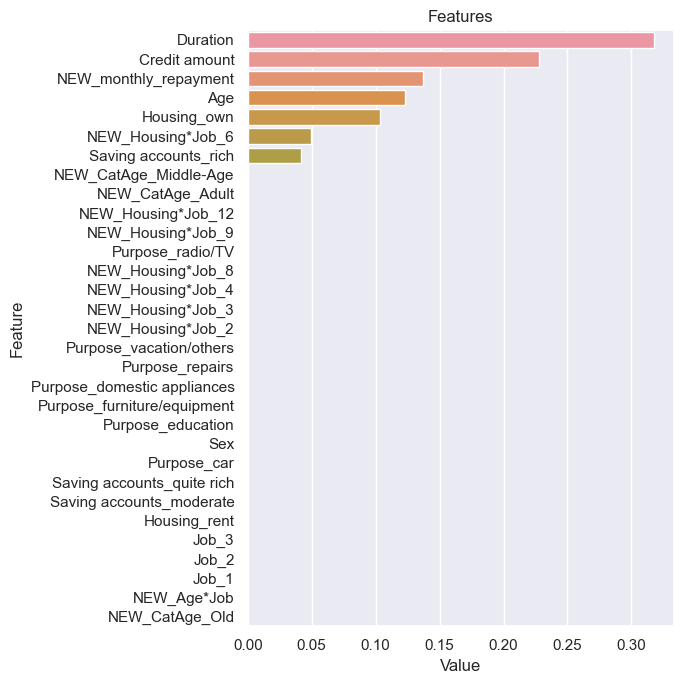

In [1046]:
plot_importance(decision_tree_final, X)

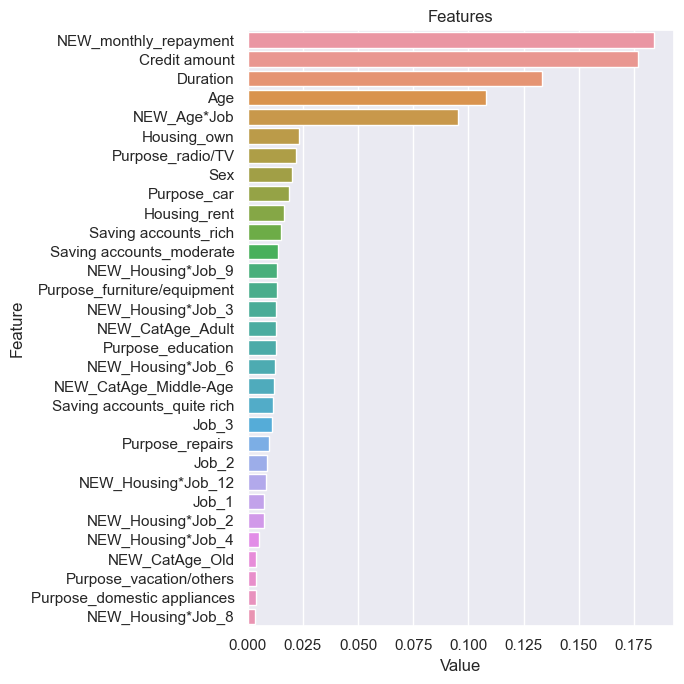

In [1047]:
plot_importance(rf_final, X)

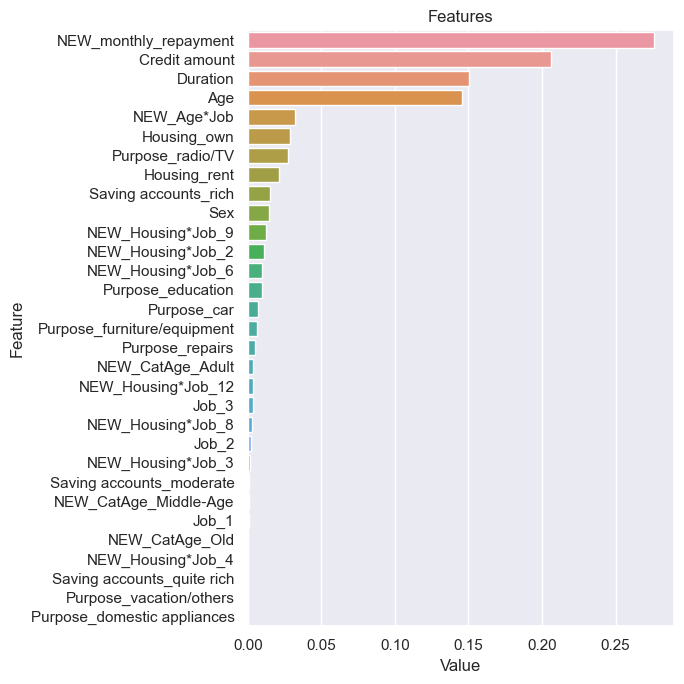

In [1048]:
plot_importance(gbm_final, X)

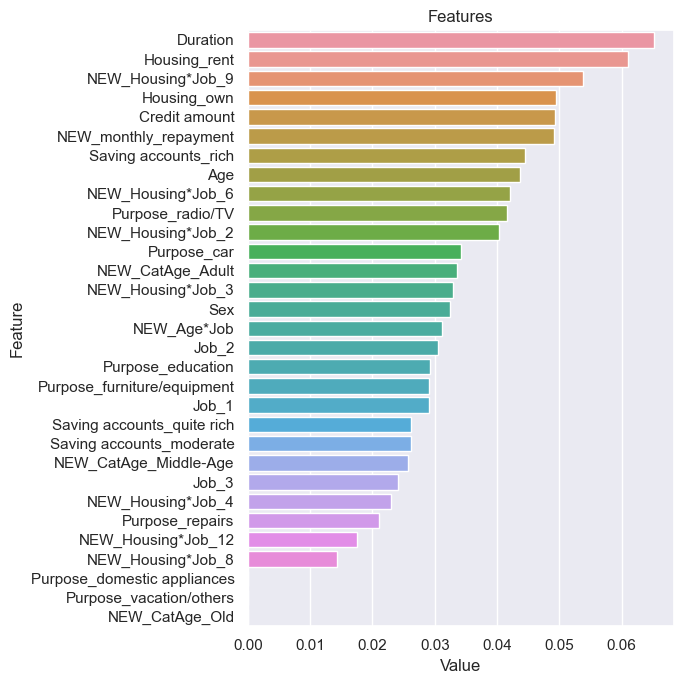

In [1051]:
plot_importance(xgboost_final, X)

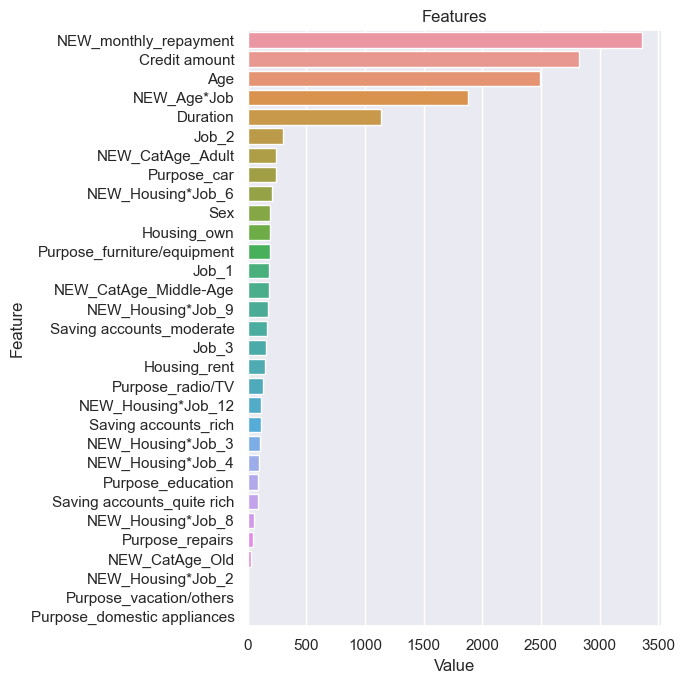

In [1052]:
plot_importance(lgbm_final, X)

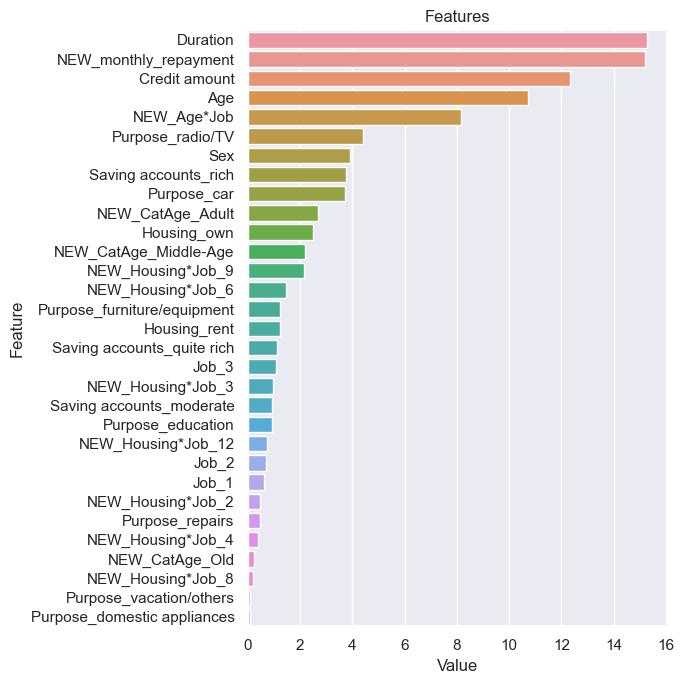

In [1053]:
plot_importance(catboost_final, X)